In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Utilities
from PIL import Image
from IPython import display
from tqdm import tqdm # for training progress

# Parameters
Change based on system

In [2]:
EPOCHS = 100 # Do not change unless testing
BATCH_SIZE = 100 # Based on system 
DATASET_PATH = "./dataset/" # Based on system

IMAGE_SHAPE = (64, 64, 3) # Should not change
LATENT_DIM = 32 # Do not change unless testing, the smaller the better

# Utilities Functions

In [3]:
def compare_and_show_images(original: np.ndarray, generated: np.ndarray, id: str, save: bool=True):
    """
    Compare and show original vs generated images.
    Only allow 2 images to be compared against 2 images.
    Allow for a visual check of the model's progress.
    Parameters:
        - original: numpy array containing the original images (shape (4, 64, 64, 3))
        - generated: numpy array containing the corresponding generated images (shape (4, 64, 64, 3))
        - id: something to save using
        - save: whether to save or not
    """
    fig = plt.figure(figsize=(2, 2))

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(generated[i])
        plt.axis('off')

        plt.subplot(2, 2, i+3)
        plt.imshow(original[i])
        plt.axis('off')

    if save:
        plt.savefig("./generated_images/{}.png".format(id))
        plt.show()

# Load Data
Done in batches

In [4]:
from keras.utils import image_dataset_from_directory

x_train, x_test = image_dataset_from_directory(
    DATASET_PATH, 
    labels=None, 
    batch_size=BATCH_SIZE, 
    image_size=IMAGE_SHAPE[:-1], 
    shuffle=False, # Don't think this matters
    validation_split=0.1, 
    subset="both",
    crop_to_aspect_ratio=True)

Found 202599 files belonging to 1 classes.
Using 182340 files for training.
Using 20259 files for validation.


In [5]:
# Normalize dataset
x_train = x_train.map(lambda x: x/255)
x_test = x_test.map(lambda x: x/255)

Show a few images from the dataset

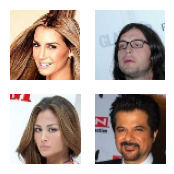

In [6]:
# Need to investigate memory usage, but should be good
train_iter, test_iter = x_train.as_numpy_iterator(), x_test.as_numpy_iterator()

fig = plt.figure(figsize=(2, 2))

plt.subplot(2, 2, 1)
plt.imshow(next(train_iter)[0]) # First image of batch 0 of x_train
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(next(train_iter)[1]) # Second image of batch 1 of x_train for variety's sakes
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(next(test_iter)[0]) # First image of batch 0 of x_test
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(next(test_iter)[1]) # Second image of batch 1 of x_test for variety's sakes
plt.axis('off')

plt.show()

# Model Definition

In [7]:
from keras import models, layers, Model

### Encoder Model

In [8]:
encoder = models.Sequential([
    layers.InputLayer(input_shape=IMAGE_SHAPE),
    # Fill in the rest of the model
    layers.Flatten(),
    layers.Dense(LATENT_DIM, activation='sigmoid') # Number of features we're condensing down to
], name="face_encoder")

encoder.summary()

Model: "face_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 32)                393248    
                                                                 
Total params: 393248 (1.50 MB)
Trainable params: 393248 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Decoder Model

In [9]:
decoder = models.Sequential([
    layers.InputLayer(input_shape=(LATENT_DIM)),
    layers.Dense(np.prod(IMAGE_SHAPE)),
    # Fill in the rest of the model, or replace this whole thing
    layers.Reshape(IMAGE_SHAPE)
], name="face_decoder")

decoder.summary()

Model: "face_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12288)             405504    
                                                                 
 reshape (Reshape)           (None, 64, 64, 3)         0         
                                                                 
Total params: 405504 (1.55 MB)
Trainable params: 405504 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Deepfake Detector

In [14]:
discriminator = models.Sequential([
    layers.Conv2D(3, 7, 1, activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(64, 5, 2, activation='relu'),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(128, 3, 2, activation='relu'),
    layers.MaxPool2D(2, 2),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
], name="face_discriminator")

discriminator.summary()
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

Model: "face_discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 58, 58, 3)         444       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 29, 29, 3)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 64)        4864      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 2, 2, 128)         73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 1, 1, 128)  

### Variational Autoencoder
Allow for the use of the Keras model API

In [10]:
class Autoencoder(Model):
  def __init__(self, encoder_model, decoder_model):
    super().__init__()
    self.encoder = encoder_model
    self.decoder = decoder_model

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(encoder, decoder)
autoencoder.compile(optimizer='adam', loss='mse')

### Convolutional Generative Adversarial Network
Also allow for the use of the Keras model API. Follow this [guide](https://keras.io/examples/generative/conditional_gan/).

In [ ]:
class ConvolutionalGAN(Model):
  def __init__(self, generator_model, discriminator_model):
    super().__init__()
    self.generator = generator_model
    self.discriminator = discriminator_model
    self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
    self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

  @property
  def metrics(self):
    return [self.gen_loss_tracker, self.disc_loss_tracker]

  def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
    super().compile()
    self.generator.compile(optimizer=g_optimizer, loss=g_loss_fn)
    self.discriminator.compile(optimizer=d_optimizer, loss=d_loss_fn)

  def call(self, x):
    image = self.generator(image)
    return image

  def train_step(self, data):
    # TODO
    return {
            "gen_loss": self.gen_loss_tracker.result(),
            "disc_loss": self.disc_loss_tracker.result(),
        }

dcgan = ConvolutionalGAN(autoencoder, discriminator)
dcgan.compile(
  d_optimizer='adam', 
  g_optimizer='adam', 
  d_loss_fn='binary_crossentropy',
  g_loss_fn='mse'
)

# Train Model

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=EPOCHS,
                validation_data=(x_test, x_test))

# Test Model 

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()